In [34]:
import numpy as np
from numpy.random import uniform
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import neural_network
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import completeness_score

In [35]:
# Calculează distanța euclidiană între un punct și un set de date
def euclidean(point, data):
    return np.sqrt(np.sum((point - data) ** 2, axis=1))


class MyKMeans:
    def __init__(self, n_clusters=8, max_iter=750):
        self.centroids = None
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        self.centroids = [random.choice(X)]  # Inițializează centroizii cu un punct aleatoriu
        for _ in range(self.n_clusters - 1):
            # Calculează distanțele de la puncte la centroizi
            dists = np.sum([euclidean(centroid, X) for centroid in self.centroids], axis=0)
            dists /= np.sum(dists)  # Normalizează distanțele
            new_centroid_index, = np.random.choice(range(len(X)), size=1, p=dists)
            # Alege punctele rămase în funcție de distanțele lor
            self.centroids += [X[new_centroid_index]]

        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            sorted_points = [[] for _ in range(self.n_clusters)]  # Atribuie fiecare dată celui mai apropiat centroid
            for x in X:
                dists = euclidean(x, self.centroids)
                centroid_index = np.argmin(dists)  # Alege distanța minimă
                sorted_points[centroid_index].append(x)
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            # Realocă centroizii ca medie a punctelor care aparțin lor

            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = prev_centroids[i]
            iteration += 1

    def evaluate(self, X):
        centroids = []
        centroid_indexes = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_index = np.argmin(dists)
            centroids.append(self.centroids[centroid_index])
            centroid_indexes.append(centroid_index)
        return centroids, centroid_indexes


In [36]:
# Încarcă setul de date pentru flori
def load_data_flowers():
    data = load_iris()
    input_data = data['data']  # Datele de intrare
    output_data = data['target']  # Datele de ieșire
    outputs_name = data['target_names']  # Numele claselor de ieșire
    feature_names = list(data['feature_names'])  # Numele caracteristicilor
    feature_1 = [feat[feature_names.index('sepal length (cm)')] for feat in input_data]  # Caracteristica 1 (lungimea sepalei)
    feature_2 = [feat[feature_names.index('sepal width (cm)')] for feat in input_data]  # Caracteristica 2 (lățimea sepalei)
    feature_3 = [feat[feature_names.index('petal length (cm)')] for feat in input_data]  # Caracteristica 3 (lungimea petalei)
    feature_4 = [feat[feature_names.index('petal width (cm)')] for feat in input_data]  # Caracteristica 4 (lățimea petalei)
    input_data = [[feat[feature_names.index('sepal length (cm)')],
                   feat[feature_names.index('sepal width (cm)')],
                   feat[feature_names.index('petal length (cm)')],
                   feat[feature_names.index('petal width (cm)')]] for feat in input_data]
    # Rearanjează datele de intrare pentru a avea toate caracteristicile într-o singură listă
    return input_data, output_data, outputs_name, feature_1, feature_2, feature_3, feature_4, feature_names

# Generează un grafic de dispersie pentru setul de date pentru flori
def plot_data_flowers(input_data, output_data, feature_names):
    sns.scatterplot(x=[X[2] for X in input_data],
                    y=[X[3] for X in input_data],
                    hue=output_data,
                    palette="deep",
                    legend=None,
                    s=100)
    plt.xlabel(feature_names[2])  # Eticheta axei x
    plt.ylabel(feature_names[3])  # Eticheta axei y
    plt.title("Toate datele inițiale pentru flori")
    plt.show()

# Încarcă setul de date pentru spam
def load_data_spam(filename):
    file = pd.read_csv(filename, encoding="ISO-8859-1")
    input_data = [value for value in file["emailText"]]  # Datele de intrare
    output_data = [value for value in file["emailType"]]  # Datele de ieșire
    label_names = list(set(output_data))  # Numele etichetelor de ieșire
    return input_data, output_data, label_names

# Încarcă setul de date pentru emoții
def load_data_emotions(filename):
    file = pd.read_csv(filename, encoding="ISO-8859-1")
    input_data = [value for value in file["Text"]]  # Datele de intrare
    output_data = [value for value in file["Sentiment"]]  # Datele de ieșire
    label_names = list(set(output_data))  # Numele etichetelor de ieșire
    return input_data, output_data, label_names



In [37]:
def train_and_test(input_data, output_data):
    indexes = [i for i in range(len(input_data))]
    train_sample = np.random.choice(indexes, int(0.8 * len(input_data)), replace=False)
    test_sample = [i for i in indexes if i not in train_sample]
    train_inputs = [input_data[i] for i in train_sample]
    train_outputs = [output_data[i] for i in train_sample]
    test_inputs = [input_data[i] for i in test_sample]
    test_outputs = [output_data[i] for i in test_sample]
    return train_inputs, train_outputs, test_inputs, test_outputs


def normalisation(train_data, test_data):
    scaler = StandardScaler()
    if not isinstance(train_data[0], list):
        trainData = [[d] for d in train_data]
        testData = [[d] for d in test_data]
        scaler.fit(trainData)
        normalisedTrainData = scaler.transform(trainData)
        normalisedTestData = scaler.transform(testData)
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(train_data)
        normalisedTrainData = scaler.transform(train_data)
        normalisedTestData = scaler.transform(test_data)
    return normalisedTrainData, normalisedTestData

In [38]:
# Extrage caracteristicile folosind reprezentarea Bag of Words
def extract_features_bag_of_words(train_inputs, test_inputs):
    vec = CountVectorizer()  # Inițializează vectorizatorul CountVectorizer
    train_features = vec.fit_transform(train_inputs)  # Transformă datele de antrenament în caracteristici
    test_features = vec.transform(test_inputs)  # Transformă datele de test în caracteristici folosind aceeași transformare
    return train_features.toarray(), test_features.toarray()  # Returnează caracteristicile ca matrice numpy

# Extrage caracteristicile folosind reprezentarea TF-IDF(Term Frequency - Inverse Document Frequency)
def extract_features_tf_idf(train_inputs, test_inputs, max_features):
    vec = TfidfVectorizer(max_features=max_features)  # Inițializează vectorizatorul TfidfVectorizer cu numărul maxim de caracteristici
    train_features = vec.fit_transform(train_inputs)  # Transformă datele de antrenament în caracteristici
    test_features = vec.transform(test_inputs)  # Transformă datele de test în caracteristici folosind aceeași transformare
    return train_features.toarray(), test_features.toarray()  # Returnează caracteristicile ca matrice numpy

# Extrage caracteristicile folosind reprezentarea Hashing
def extract_features_hashing(train_inputs, test_inputs, n_features):
    vec = HashingVectorizer(n_features=n_features)  # Inițializează vectorizatorul HashingVectorizer cu numărul de caracteristici
    train_features = vec.fit_transform(train_inputs)  # Transformă datele de antrenament în caracteristici
    test_features = vec.transform(test_inputs)  # Transformă datele de test în caracteristici folosind aceeași transformare
    return train_features.toarray(), test_features.toarray()  # Returnează caracteristicile ca matrice numpy


In [39]:
# Prezicerea utilizând tool-uri de învățare nesupervizată (K-means)
def predict_by_tool(train_features, test_features, label_names, classes):
    unsupervisedClassifier = KMeans(n_clusters=classes, random_state=0)  # Inițializează clasificatorul K-means mic
    unsupervisedClassifier.fit(train_features)  # Antrenează clasificatorul utilizând caracteristicile de antrenament
    computed_indexes = unsupervisedClassifier.predict(test_features)  # Prezice etichetele pentru caracteristicile de test
    computed_outputs = [label_names[value] for value in computed_indexes]  # Converteste indicii prezise în etichete
    return computed_outputs

# Prezicerea utilizând o implementare proprie a algoritmului K-means
def predict_by_me(train_features, test_features, label_names, classes):
    my_unsupervised_classifier = MyKMeans(n_clusters=classes)  # Inițializează clasificatorul K-means personalizat
    my_unsupervised_classifier.fit(train_features)  # Antrenează clasificatorul utilizând caracteristicile de antrenament
    my_centroids, computed_indexes = my_unsupervised_classifier.evaluate(test_features)  # Evaluează caracteristicile de test
    computed_outputs = [label_names[value] for value in computed_indexes]  # Converteste indicii prezise în etichete
    return computed_outputs, my_centroids, computed_indexes

# Prezicerea utilizând un algoritm de învățare supervizată (MLP - perceptron multicouche)
def predict_supervised(train_inputs, train_outputs, test_inputs):
    classifier = neural_network.MLPClassifier(hidden_layer_sizes=(25, 40, 20), activation='relu', max_iter=1000,
                                              solver='sgd',
                                              verbose=0, random_state=1, learning_rate_init=.01)  # Inițializează clasificatorul MLP
    classifier.fit(train_inputs, train_outputs)  # Antrenează clasificatorul utilizând datele de antrenament
    computed_outputs = classifier.predict(test_inputs)  # Prezice etichetele pentru datele de test
    return computed_outputs

# Prezicerea utilizând o abordare hibridă semi-supervizată
def predict_hybrid(train_inputs, train_outputs, test_inputs, test_outputs):
    n = 100  # 100 de intrări vor avea etichete
    classifier = neural_network.MLPClassifier()  # Inițializează clasificatorul MLP
    classifier.fit(train_inputs[:n], train_outputs[:n])  # Antrenează clasificatorul utilizând primele n date de antrenament
    computed_outputs = classifier.predict(test_inputs)  # Prezice etichetele pentru datele de test
    prev_acc = accuracy_score(test_outputs, computed_outputs)  # Calculează acuratețea anterioară

    unsupervised_classifier = KMeans(n_clusters=n, random_state=0)  # Inițializează clasificatorul K-means
    x = unsupervised_classifier.fit_transform(train_inputs)  # Calculează matricea de distanță între puncte și centroizi
    representative_indexes = np.argmin(x, axis=0)  # Determină indicii celor mai reprezentative puncte
    representative_inputs = [train_inputs[i] for i in representative_indexes]  # Obține intrările celor mai reprezentative puncte
    representative_outputs = [list(train_outputs)[x] for x in representative_indexes]  # Obține etichetele celor mai reprezentative puncte
    classifier = neural_network.MLPClassifier()  # Inițializează un nou clasificator MLP
    classifier.fit(representative_inputs, representative_outputs)  # Antrenează clasificatorul utilizând datele cele mai reprezentative
    computed_outputs = classifier.predict(test_inputs)  # Prezice etichetele pentru datele de test
    return computed_outputs, prev_acc


In [40]:
def plot_result_flowers(test_inputs, test_outputs, centroids, classification):
    # Plotează punctele de testare într-un grafic de dispersie
    sns.scatterplot(x=[X[2] for X in test_inputs],  # Coordonata x a punctelor de test
                    y=[X[3] for X in test_inputs],  # Coordonata y a punctelor de test
                    hue=test_outputs,  # Etichetele reale ale punctelor de test
                    style=classification,  # Etichetele prezise pentru punctele de test
                    palette="deep",  # Paleta de culori
                    legend=None,  # Nu afișa legenda
                    s=100)  # Dimensiunea punctelor

    # Plotează centroizii ca semne de plus
    plt.plot([x[2] for x in centroids],  # Coordonata x a centroizilor
             [y[3] for y in centroids],  # Coordonata y a centroizilor
             'k+',  # Tipul și culoarea marcatorului
             markersize=10)  # Dimensiunea marcatorului

    plt.title("Test data flowers classification")  # Setează titlul graficului
    plt.show()  # Afișează graficul


IRIS


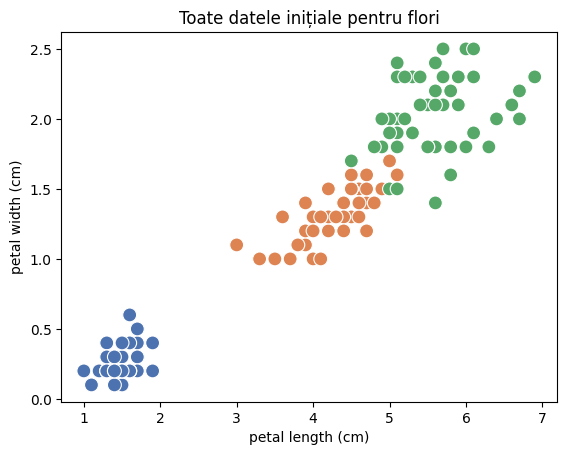

Completeness score by tool: 0.5988778264320216
Completeness score by me: 0.562875124515718


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


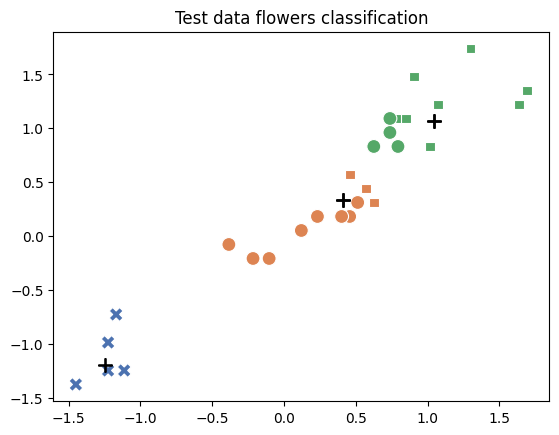


SPAM


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy score by tool: 0.6878923766816144
Accuracy score by me: 0.6869955156950672
Output computed by tool:   ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam',

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy score by tool: 0.5476190476190477
Accuracy score by me: 0.5476190476190477
Accuracy score supervised: 0.7142857142857143
Accuracy score hybrid before KMeans: 0.7380952380952381
Accuracy score hybrid after KMeans: 0.7380952380952381
Output computed by tool:   ['positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative']
Output computed by me:     ['positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negati

/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
print("IRIS")
# Încarcă datele pentru setul de flori Iris
inputs, outputs, labelsNames, feature1, feature2, feature3, feature4, featureNames = load_data_flowers()
# Plotează datele inițiale ale florilor
plot_data_flowers(inputs, outputs, featureNames)
# Separă datele în setul de antrenare și setul de testare
trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
# Efectuează normalizarea asupra datelor de antrenare și de testare
trainInputs, testInputs = normalisation(trainInputs, testInputs)
# Prezice rezultatele utilizând metoda "predict_by_tool"
computedOutput = predict_by_tool(trainInputs, testInputs, labelsNames, len(set(labelsNames)))
# Calculează scorul de completitudine pentru metoda "predict_by_tool"
print('Completeness score by tool:', completeness_score(testOutputs, computedOutput))
# Prezice rezultatele utilizând metoda "predict_by_me"
computedOutput, centroids, computedIndexes = \
    predict_by_me(trainInputs, testInputs, labelsNames, len(set(labelsNames)))
# Calculează scorul de completitudine pentru metoda "predict_by_me"
print('Completeness score by me:', completeness_score(testOutputs, computedOutput))
# Plotează rezultatele clasificării florilor pe setul de testare
plot_result_flowers(testInputs, testOutputs, centroids, computedIndexes)

print("\nSPAM")
# Încarcă datele pentru setul de e-mailuri spam
inputs, outputs, labelsNames = load_data_spam('data/spam.csv')
# Separă datele în setul de antrenare și setul de testare
trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
# Extrage caracteristicile utilizând metoda "extract_features_hashing"
trainFeatures, testFeatures = extract_features_hashing(trainInputs, testInputs, 2 ** 10)
# Prezice rezultatele utilizând metoda "predict_by_tool"
computedOutputs = predict_by_tool(trainFeatures, testFeatures, labelsNames, len(set(labelsNames)))
# Prezice rezultatele utilizând metoda "predict_by_me"
myComputedOutputs, centroids, computedIndexes = \
    predict_by_me(trainFeatures, testFeatures, labelsNames, len(set(labelsNames)))
# Inversează etichetele de testare pentru calcularea scorului de acuratețe inversat
inverseTestOutputs = ['spam' if elem == 'ham' else 'ham' for elem in testOutputs]
# Calculează scorurile de acuratețe pentru metoda "predict_by_tool"
accuracyByTool = accuracy_score(testOutputs, computedOutputs)
accuracyByToolInverse = accuracy_score(inverseTestOutputs, computedOutputs)
print('Accuracy score by tool:', max(accuracyByTool, accuracyByToolInverse))
# Calculează scorurile de acuratețe pentru metoda "predict_by_me"
accuracyByMe = accuracy_score(testOutputs, myComputedOutputs)
accuracyByMeInverse = accuracy_score(inverseTestOutputs, myComputedOutputs)
print('Accuracy score by me:', max(accuracyByMe, accuracyByMeInverse))
# Afișează rezultatele prezise de metoda "predict_by_tool" și "predict_by_me" și etichetele reale
print('Output computed by tool:  ', computedOutputs)
print('Output computed by me:    ', myComputedOutputs)
print('Real output:              ', testOutputs)

print("\nEMOTIONS")
# Încarcă datele pentru setul de emoții din recenzii
inputs, outputs, labelsNames = load_data_emotions('data/reviews_mixed.csv')
# Separă datele în setul de antrenare și setul de testare
trainInputs, trainOutputs, testInputs, testOutputs = train_and_test(inputs, outputs)
# Extrage caracteristicile utilizând metoda "extract_features_tf_idf"
trainFeatures, testFeatures = extract_features_tf_idf(trainInputs, testInputs, 150)
# Prezice rezultatele utilizând metoda "predict_by_tool"
computedOutputs = predict_by_tool(trainFeatures, testFeatures, labelsNames, len(set(labelsNames)))
# Prezice rezultatele utilizând metoda "predict_by_me"
myComputedOutputs, centroids, computedIndexes = \
    predict_by_me(trainFeatures, testFeatures, labelsNames, len(set(labelsNames)))
# Prezice rezultatele utilizând metoda "predict_supervised"
supervisedOutput = predict_supervised(trainFeatures, trainOutputs, testFeatures)
# Prezice rezultatele utilizând metoda "predict_hybrid"
hybridOutput, prevAcc = predict_hybrid(trainFeatures, trainOutputs, testFeatures, testOutputs)
# Inversează etichetele de testare pentru calcularea scorului de acuratețe inversat
inverseTestOutputs = ['negative' if elem == 'positive' else 'positive' for elem in testOutputs]
# Calculează scorurile de acuratețe pentru metoda "predict_by_tool"
accuracyByTool = accuracy_score(testOutputs, computedOutputs)
accuracyByToolInverse = accuracy_score(inverseTestOutputs, computedOutputs)
print('Accuracy score by tool:', max(accuracyByTool, accuracyByToolInverse))
# Calculează scorurile de acuratețe pentru metoda "predict_by_me"
accuracyByMe = accuracy_score(testOutputs, myComputedOutputs)
accuracyByMeInverse = accuracy_score(inverseTestOutputs, myComputedOutputs)
print('Accuracy score by me:', max(accuracyByMe, accuracyByMeInverse))
# Calculează scorul de acuratețe pentru metoda "predict_supervised"
print('Accuracy score supervised:', accuracy_score(testOutputs, supervisedOutput))
# Calculează scorul de acuratețe inițial pentru metoda "predict_hybrid"
print('Accuracy score hybrid before KMeans:', prevAcc)
# Calculează scorul de acuratețe final pentru metoda "predict_hybrid"
print('Accuracy score hybrid after KMeans:', accuracy_score(testOutputs, hybridOutput))
# Afișează rezultatele prezise de metoda "predict_by_tool", "predict_by_me", "predict_supervised" și "predict_hybrid" și etichetele reale
print('Output computed by tool:  ', computedOutputs)
print('Output computed by me:    ', myComputedOutputs)
print('Output for supervised:    ', list(supervisedOutput))
print('Output for hybrid:        ', list(hybridOutput))
print('Real output:              ', testOutputs)
